## Ecommerce Trade Sales

In [2]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import *
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

### Reading and Filtering data

In [3]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [4]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [5]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


### Time series plot of Ecommerce trade sales

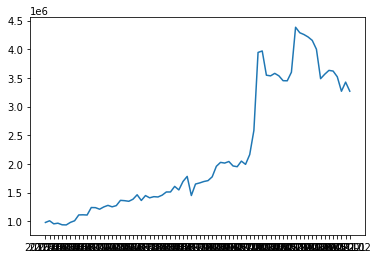

In [6]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index = retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [7]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [9]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales
Date,
2016-01,977198
2016-02,1006610


**Growth Rate of Ecommerce Retail Sales**

In [10]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()
retailEcommercesales_ts = retailEcommercesales_ts.dropna() # removing NA
retailEcommercesales_ts.index = pd.to_datetime(retailEcommercesales_ts[['Growth_rate']].index)
#plt.plot(retailEcommercesales_ts['Growth_rate'])
#plt.show()

In [11]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


**Time series for growth rate**

In [12]:
def plot_df(y, title="", xlabel='Date', ylabel='Value', dpi=100, width = 16, height = 5):
    plt.figure(figsize=(width,height), dpi=dpi)
    plt.plot(y)
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

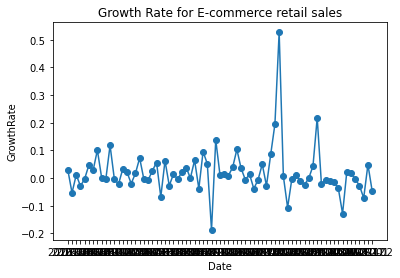

<Figure size 1600x500 with 0 Axes>

In [25]:
# Plot

plt.plot(retailEcommercesales_ts['Growth_rate'], marker = 'o')

# Labelling
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize = (16,5), dpi = 100)

# Display
plt.show()

### Stationarity Statistical test

**KPSS and ADF Test**

In [13]:
def adf_test(timeseries):
    #print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    #print(dfoutput)
    if dftest[1] < 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"


def kpss_test(timeseries):
    #print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        return f"Series is stationary"
    else:
        return f"Series is not stationary"
        
def check_stationarity(dataframe):
    for i in range(0,dataframe.shape[1]):
        timeseries = dataframe.iloc[:,i]
        adf_result = adf_test(timeseries)
        kpss_result = kpss_test(timeseries)
        if (adf_result == "Series is stationary") and (kpss_result == "Series is stationary"):
            pass
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary")
        elif (adf_result == "Series is stationary") and (kpss_result == "Series is not stationary"):
            print(f"Series {dataframe.columns[i]} is not stationary, differencing can be used to make it stationary")
        elif (adf_result == "Series is not stationary") and (kpss_result == "Series is stationary"):
            print(f"Series {dataframe.columns[i]} is trend stationary, trend needs to be removed")
    print("All other series are stationary")

**Testing the ecommerce sale\'s series stationarity**

In [14]:
kpss_test(retailEcommercesales_ts['Growth_rate'])
adf_test(retailEcommercesales_ts['Growth_rate'])

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


'Series is stationary'

### Keywords extraction using PyTrend

In [27]:
pytrends = TrendReq(hl = 'en-us', backoff_factor = 0.1)

def ecommerce_trend(keywords = [''],category = '340'):  #subcat - 280
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat = category
    timeframe = '2004-01-01 2022-05-11'
    geo = 'CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop = '')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data, queries, topics

In [ ]:
data2, queries2, topics2 = ecommerce_trend(keywords = ['Doordash'],category = '340')

In [ ]:
data2.tail()

### Normalizing time series

In [13]:
keywordsDictQuery = dict() #Dictionary for queries
keywordsDictTopic = dict() #Dictionary for topic

keywords_csv = pd.read_csv('../../data/keywords_data/ECOMMERCE.csv')

In [ ]:
#

In [5]:
for index, row in keywords_csv.iterrows():
    #print(([row['Keyword']]))
    data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
    
    if index==0:
        FinalData, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        FinalData.rename(columns = {'':str(row['Keyword'])}, inplace = True)    #column name for frame
        FinalData=FinalData.drop(columns=['isPartial'])   #remove column
    else:
        data, queries, topics=ecommerce_trend(keywords=[str(row['Keyword'])],category=str(row['SubcatNo']))
        data.rename(columns = {'':str(row['Keyword'])}, inplace = True)
        data=data.drop(columns=['isPartial'])
        data = data[str(row['Keyword'])]
        FinalData = FinalData.join(data)

NameError: name 'ecommerce_trend' is not defined

In [ ]:
FinalData

In [ ]:
FinalData

In [ ]:
FinalData.to_csv('EcommerceKeywordTimeSeries.csv')

**Dictionary of keywords**

In [ ]:
category_ts, queries, topics = ecommerce_trend(keywords = [''],category = '340')  #function calling

keyword_query_frame = dict()  #Dictionary for queries
keyword_topic_frame = dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [ ]:
# keywords dict

keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [ ]:
keyword_topic_frame

### Evaluating Category Time Series

In [ ]:
category_ts = category_ts.drop(columns = 'isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts = category_ts.dropna()

In [ ]:
category_ts.head(2)

In [ ]:
# Plot
plt.plot(category_ts['Growth_rate'], marker = 'o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize = (16,5), dpi = 100)


# Display
plt.show()

**Category Stationarity Test**

In [ ]:
kpss_test(category_ts['Growth_rate'])

In [ ]:
adf_test(category_ts['Growth_rate'])

### Keywords Time Series from CSV

In [15]:
ecommerce_keyword_ts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
ecommerce_keyword_ts.rename(columns = {'date':'Date'}, inplace = True)
ecommerce_keyword_ts = ecommerce_keyword_ts.set_index(['Date'])
ecommerce_keyword_ts = ecommerce_keyword_ts.dropna()


In [16]:
ecommerce_keyword_ts.head(2)

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,0,0,57,0,...,0,0,53,38,0,0,80,0,0,0
2004-02-01,0,0,0,0,0,0,0,0,12,0,...,0,0,48,45,48,0,0,0,0,0


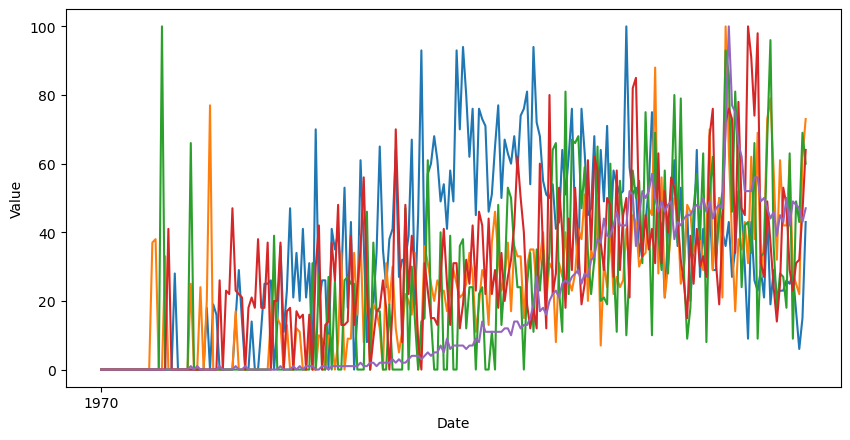

In [17]:
keywordsts = pd.read_csv('EcommerceKeywordTimeSeries.csv')
keywordsts.index = pd.to_datetime(keywordsts.index)
plot_df(keywordsts[keywordsts.columns[10:15]], width = 10)

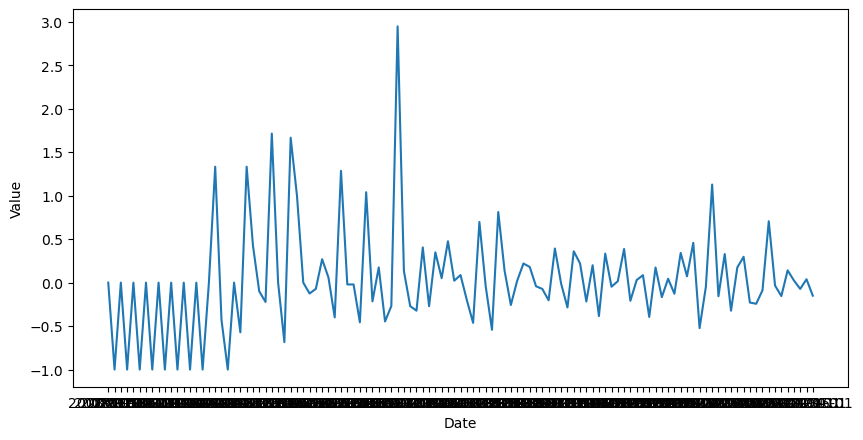

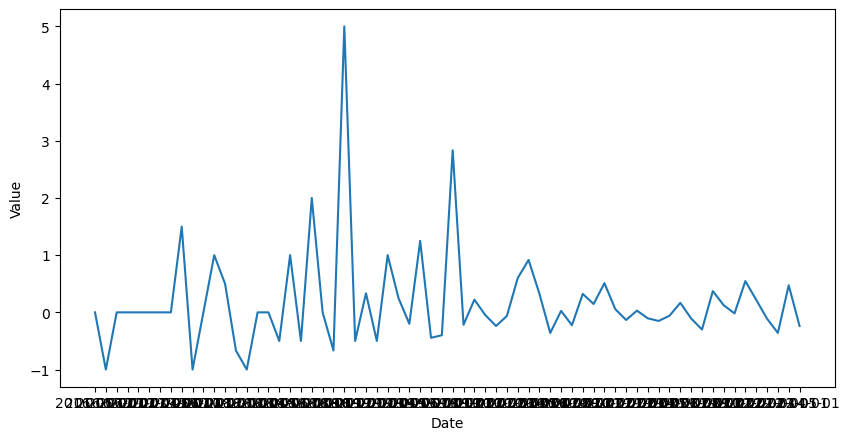

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


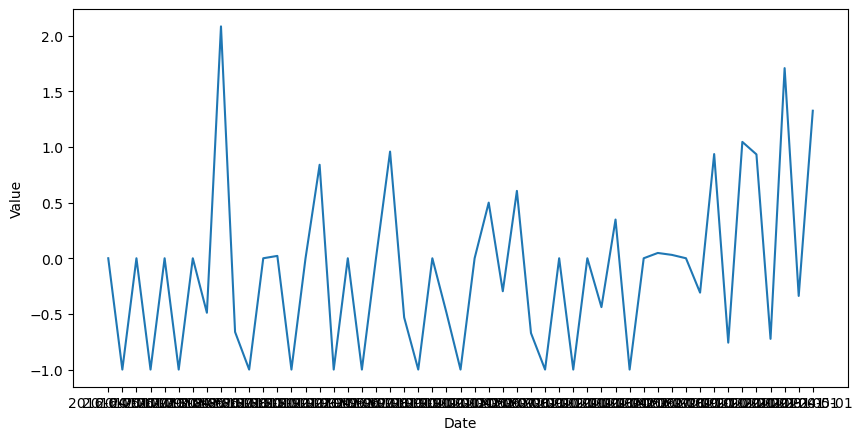

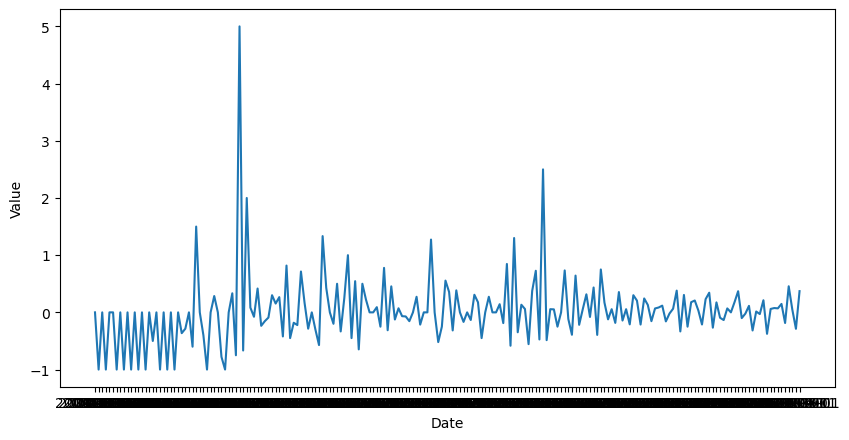

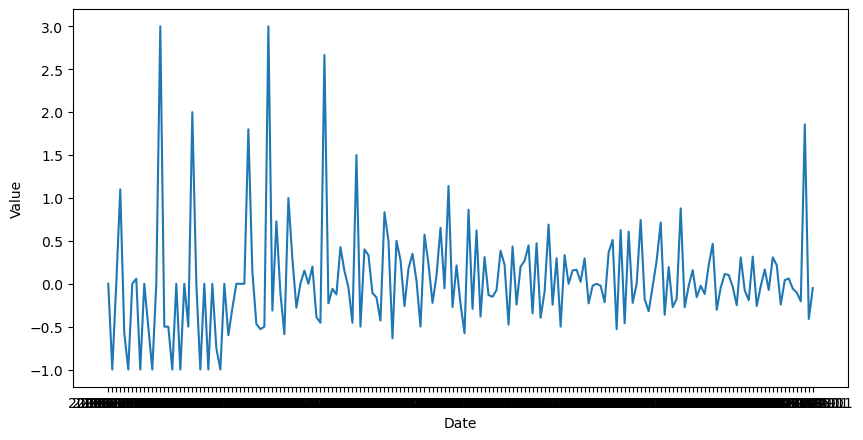

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


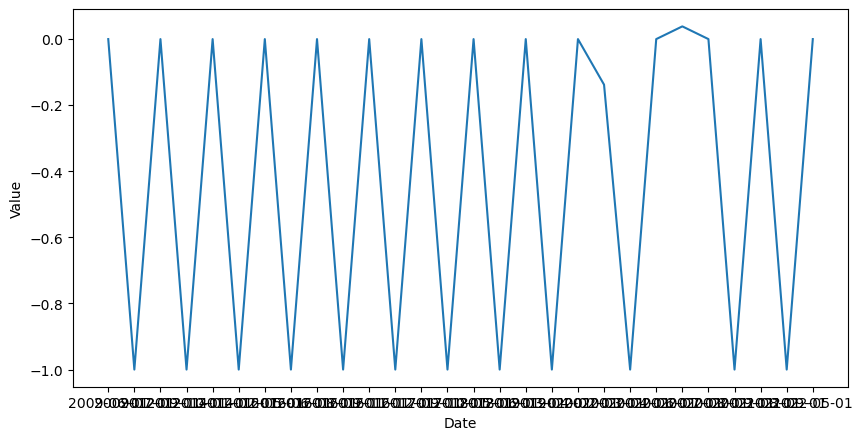

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


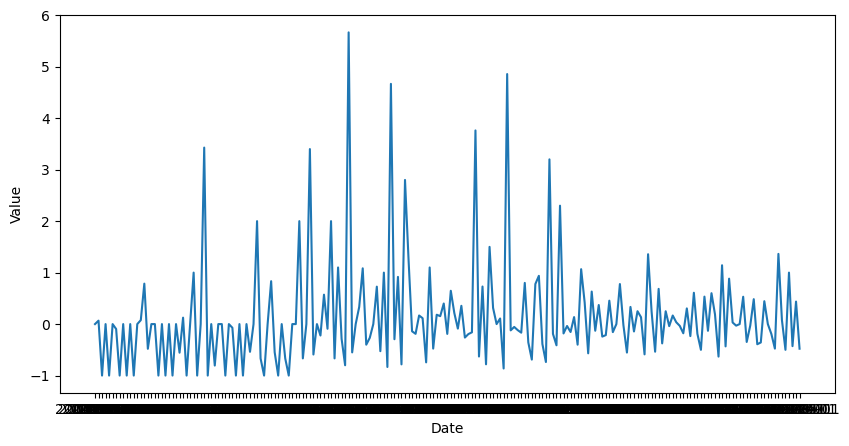

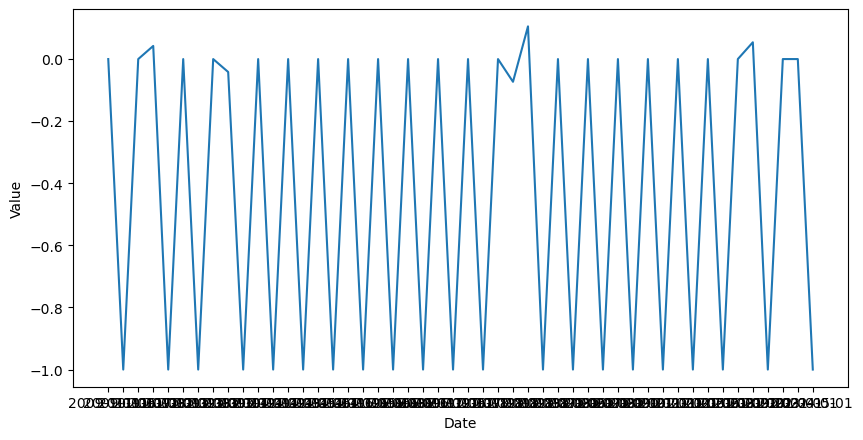

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


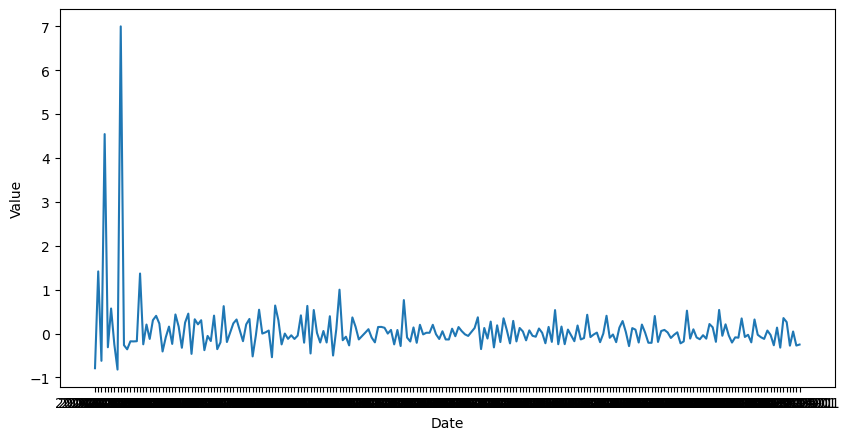

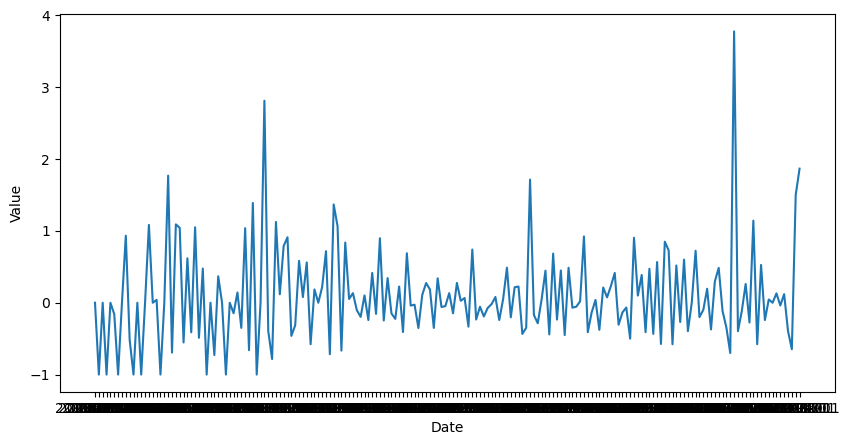

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


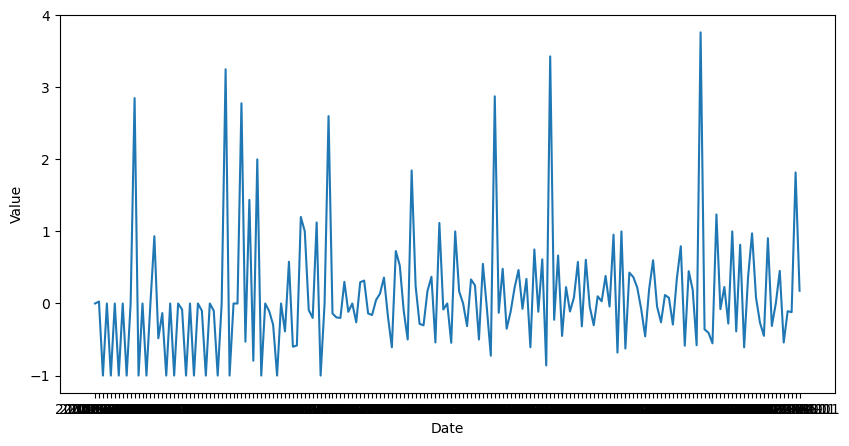

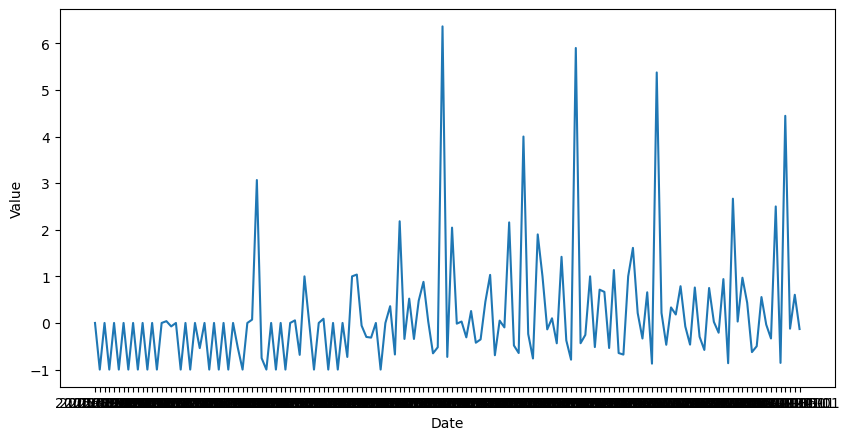

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


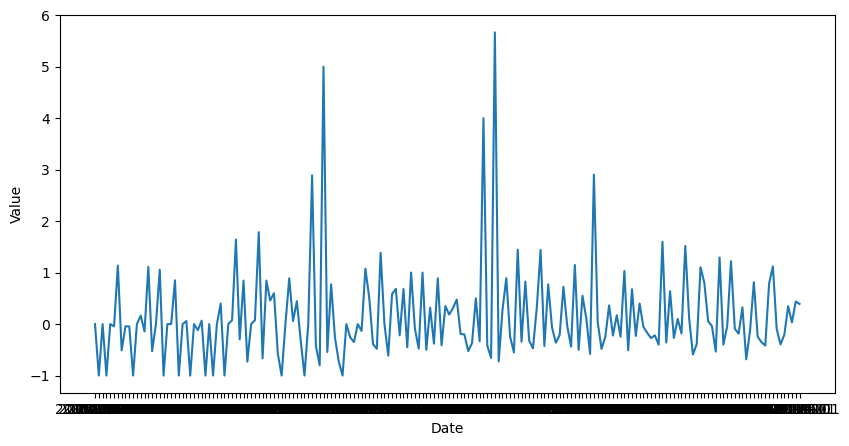

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


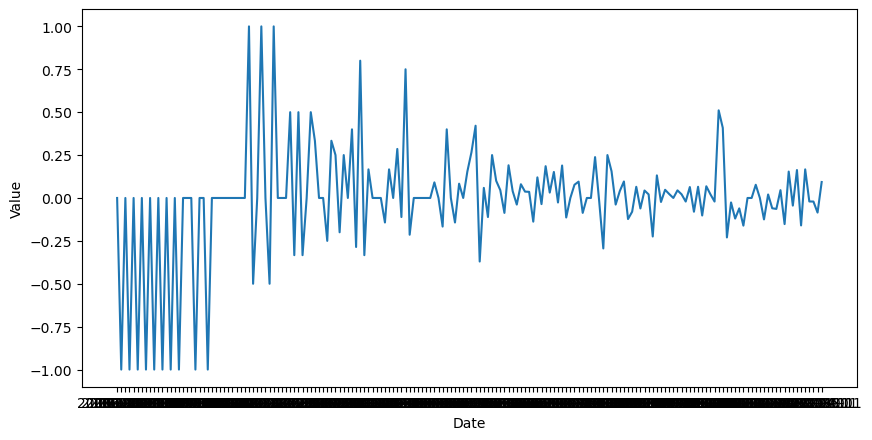

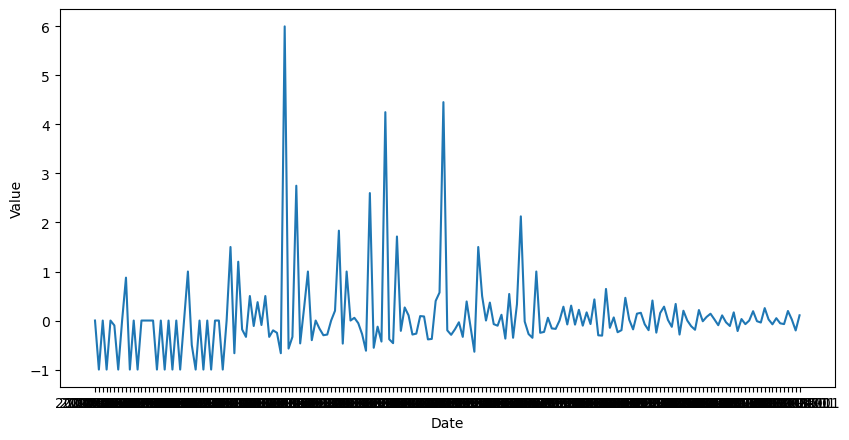

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


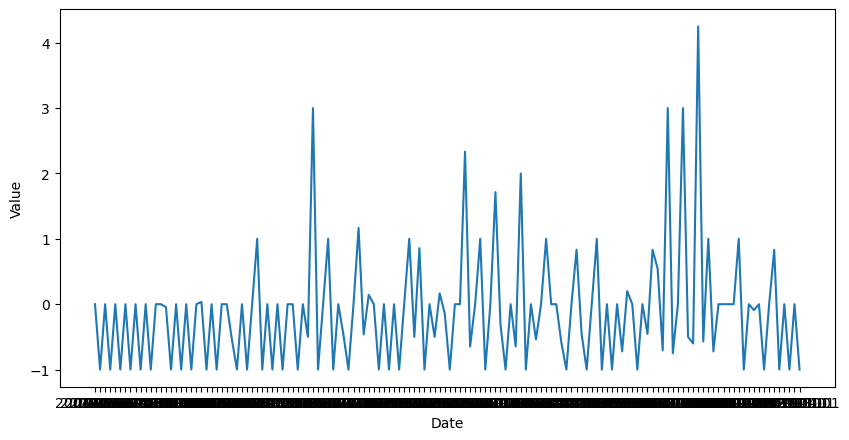

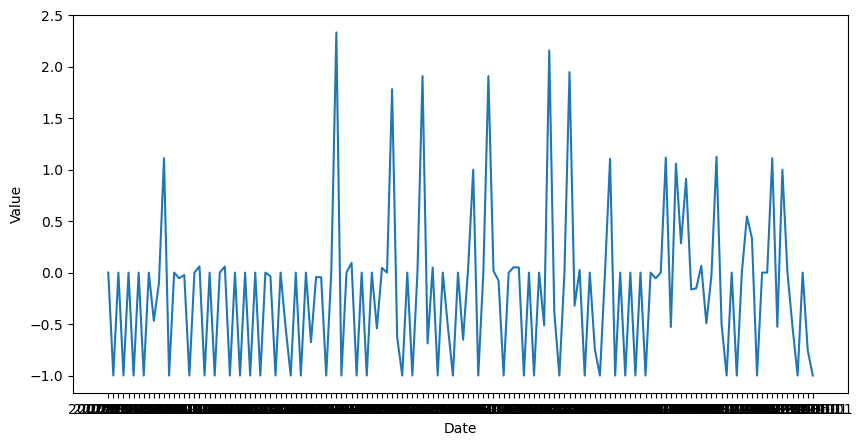

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


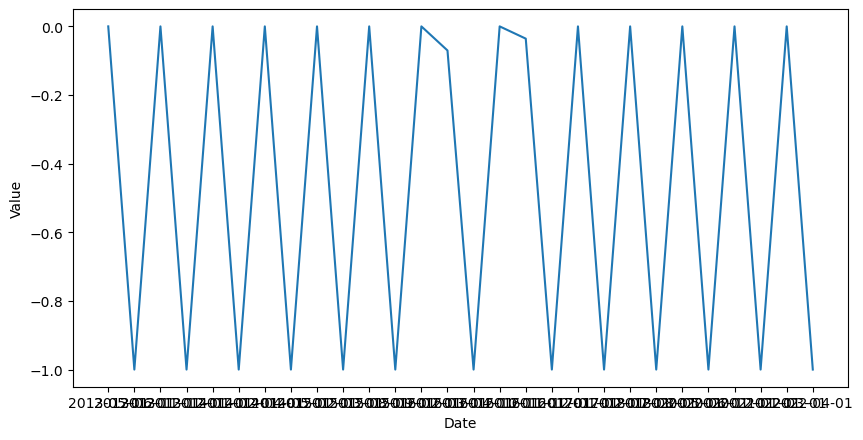

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


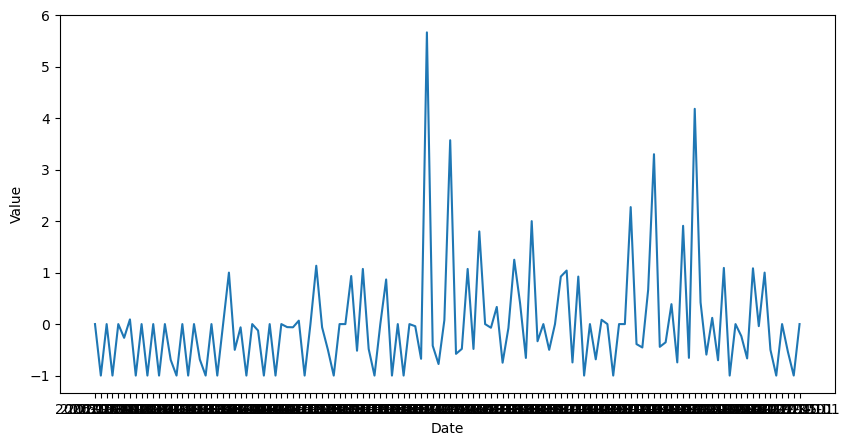

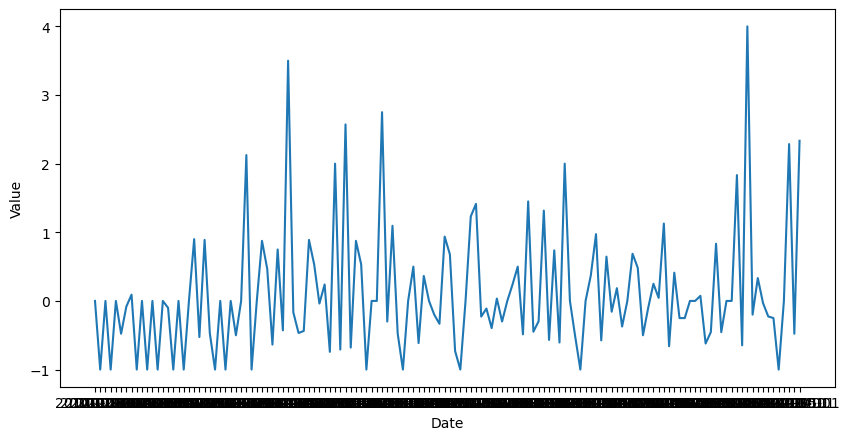

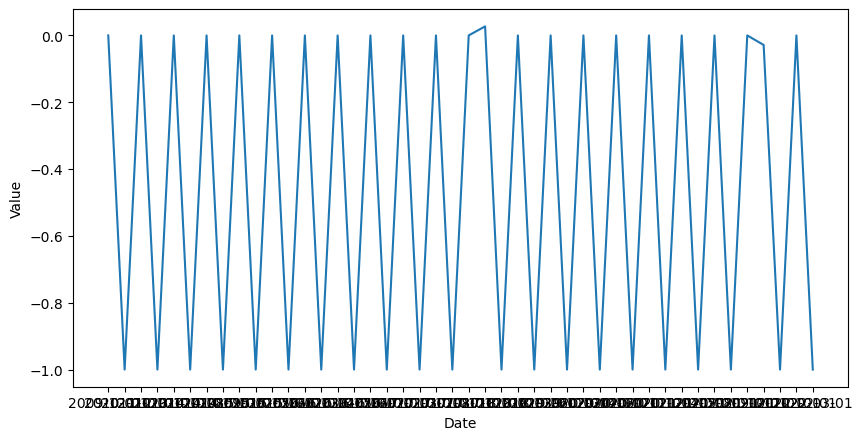

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


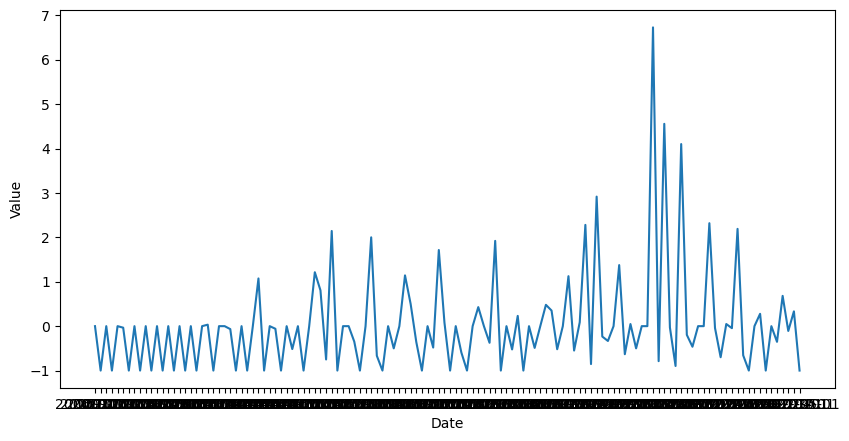

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


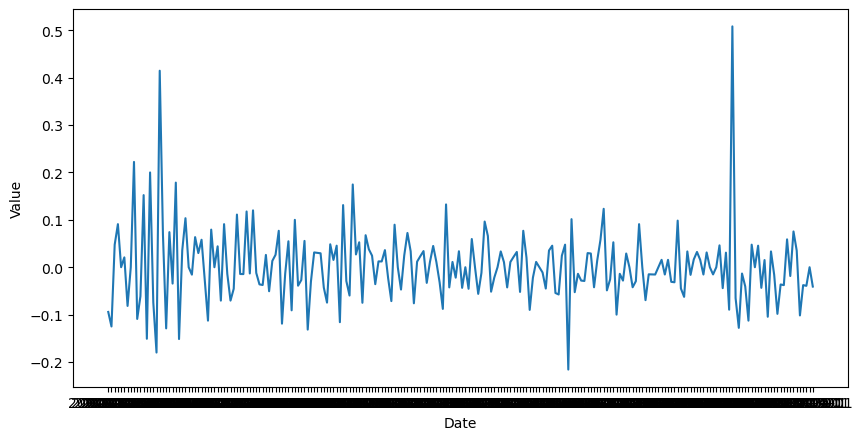

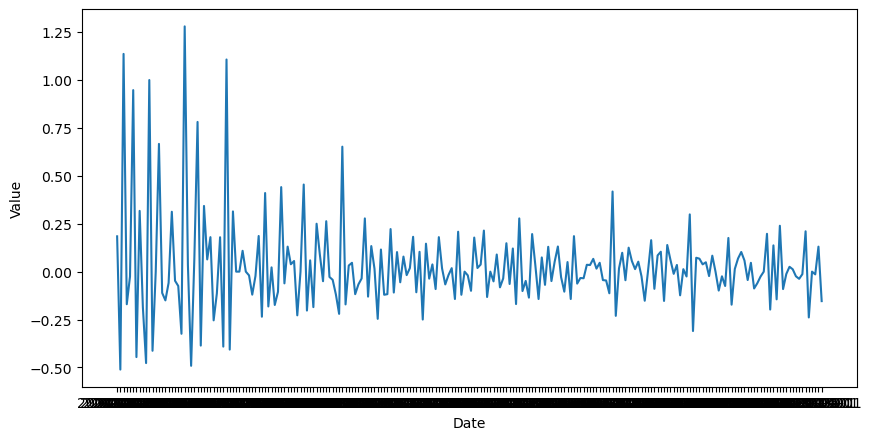

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


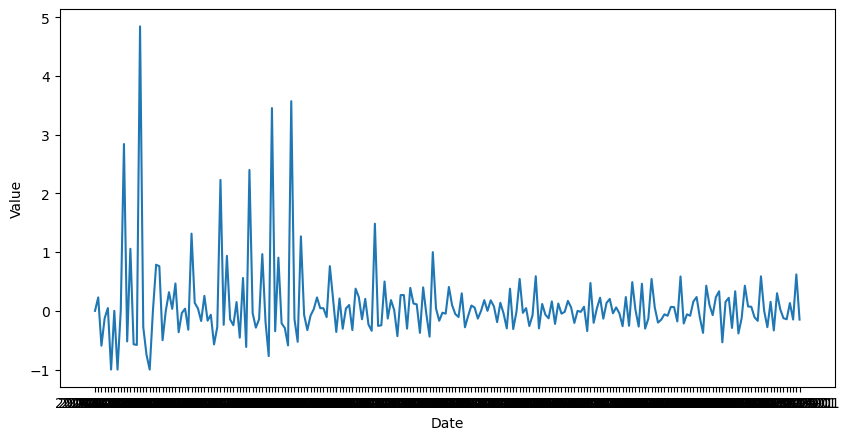

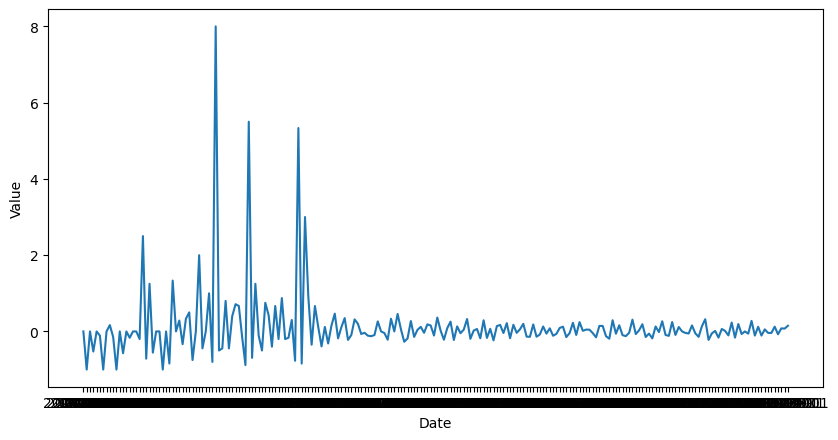

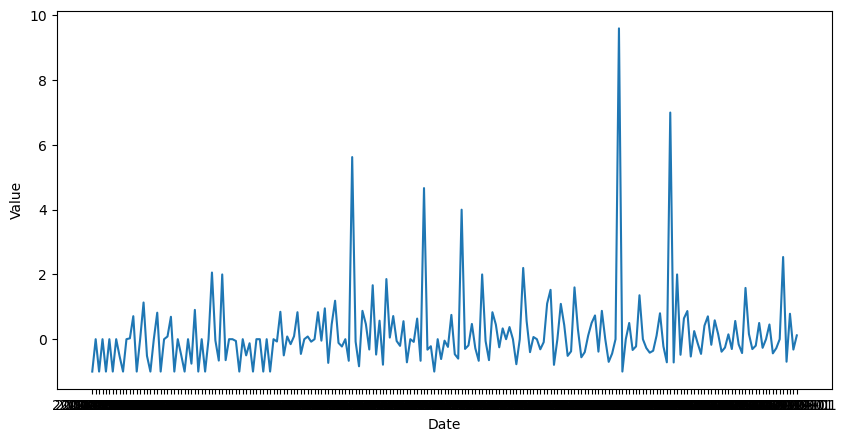

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


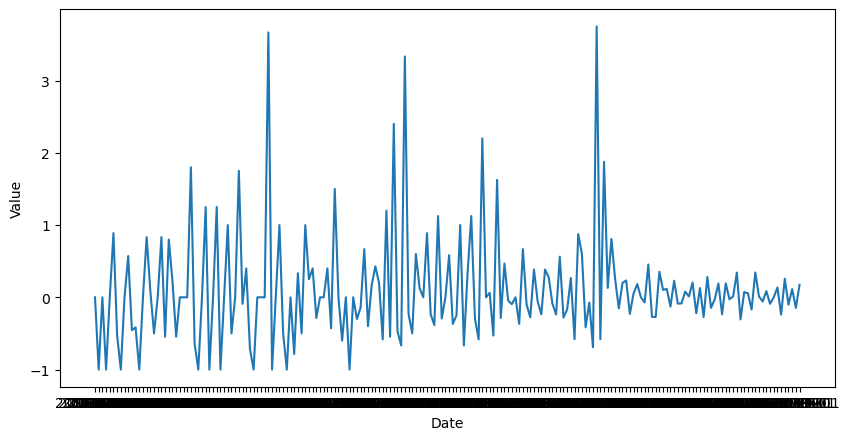

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


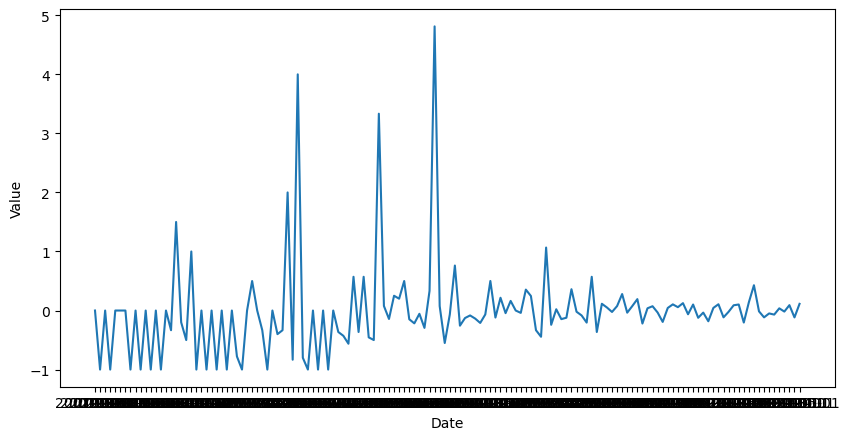

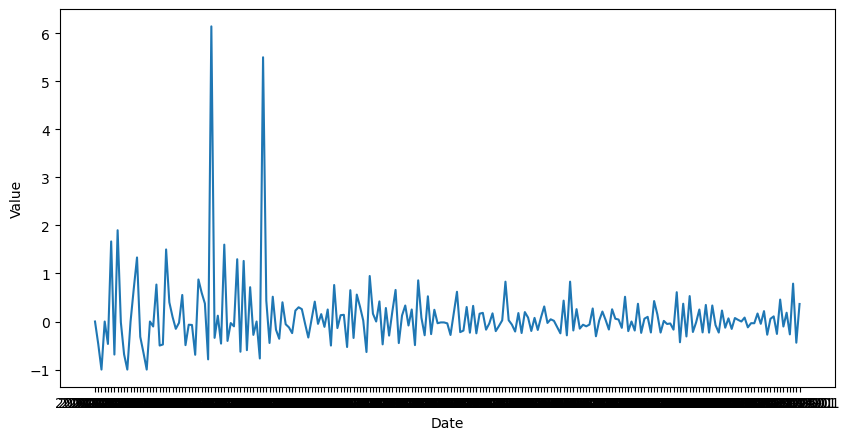

In [18]:
for column in ecommerce_keyword_ts:
    df = pd.DataFrame()
    df['Growth_rate'] = ecommerce_keyword_ts[column].pct_change()
    df = df.dropna()
    df.replace([np.inf, -np.inf], 0, inplace=True)
    plot_df(df,width=10)
    adf_test(df['Growth_rate'])
    kpss_test(df['Growth_rate'])


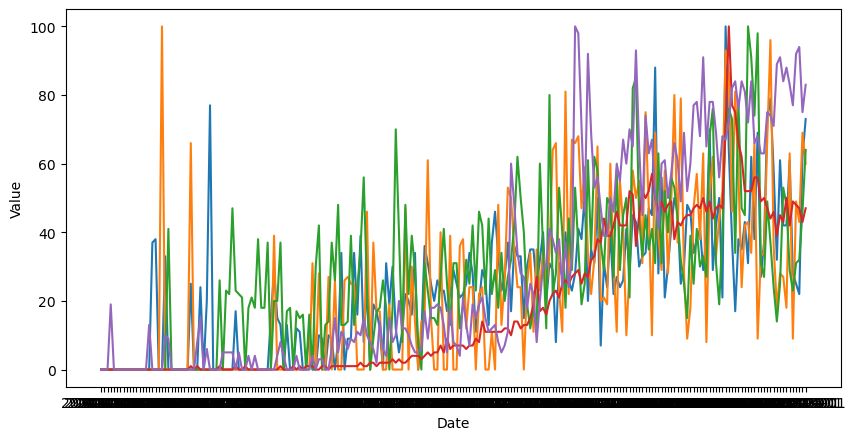

In [19]:
plot_df(ecommerce_keyword_ts[ecommerce_keyword_ts.columns[10:15]], width = 10)

In [ ]:
# get dataframe of timeseries for categories

cat_queries_dict = {}
cat_topics_dict = {}

def cat_dict():
    
    # get time series and related queries and topics of categories
    for i, category in enumerate(cat_lst):
        category = str(category)
        data, queries, topics = get_trends(category=category, related_queries=2, related_topics=2)
        cat_queries_dict[category] = queries
        cat_topics_dict[category] = topics

        #Code to append data for different columns in data frame
        if i == 0:
            data.rename(columns = {'': category}, inplace = True)
            categoryts = data.drop(columns=['isPartial'])
        else:
            data.rename(columns = {'': category}, inplace = True)
            data = data.drop(columns=['isPartial'])
            categoryts = categoryts.join(data)

# Remove the trend

### Function to extract the trend and remove it

In [20]:
def get_long_term_trend(dataframe, freq='M'):
    dataframe = np.log(dataframe)
    long_term_trend_data = dataframe.copy()
    if freq == 'Q':
        lamb = 1600
    elif freq == 'M':
        lamb = 1600*3**4
    for column_name in dataframe.columns:
        cycle, trend = sm.tsa.filters.hpfilter(dataframe[column_name], lamb)
        long_term_trend_data[column_name] = trend
    return long_term_trend_data


def remove_downward_trend_bias(dataframe, gdp_categoryts_df, freq = 'M'):
    """pass dataframe to remove bias"""
    trend_data = get_long_term_trend(gdp_categoryts_df, freq)
    log_category = np.log(dataframe)
    log_category.replace([np.inf, -np.inf], 0, inplace=True)
    avg_logcategory = log_category.mean()
    pca = PCA(n_components=1)
    pca.fit(trend_data)
    component = pd.DataFrame(pca.fit_transform(trend_data))

    # rescale component
    # transformation source link: https://stats.stackexchange.com/questions/46429/transform-data-to-desired-mean-and-standard-deviation
    rescaled_component = avg_logcategory.mean() + (component - component.mean())*(avg_logcategory.std()/component.std())
    
    # remove long term bias
    transformed_data = log_category - rescaled_component.values
    transformed_data.index = pd.to_datetime(transformed_data.index)

    return transformed_data


In [ ]:
#transformed_data = remove_downward_trend_bias(ecommerce_keyword_ts, ecommerce_keyword_ts)

In [21]:
def make_predictors_df(*arg):
    if len(arg) > 1:
        for i in range(0, len(arg)-1):
            arg[i].index = pd.to_datetime(arg[i].index)
            arg[i+1].index = pd.to_datetime(arg[i+1].index)
            predictors_df = pd.merge(arg[i], arg[i+1], left_index=True, right_index=True)
    else:
        arg[0].index = pd.to_datetime(arg[0].index)
        return arg[0]
    return predictors_df

In [18]:
predictor = make_predictors_df(ecommerce_keyword_ts)
response = make_predictors_df(retailEcommercesales_ts)

# Normalize data

In [104]:
def normalize(dataframe):
    """ function to normalize dataframe"""
    data = dataframe.copy()
    scaler = StandardScaler()
    scaler.fit(dataframe)
    scaled_df = pd.DataFrame(scaler.transform(dataframe))
    scaled_df.index = data.index
    scaled_df.columns = data.columns
    return scaled_df


# difference
def detrend(dataframe):
    return dataframe.diff().dropna()

# seasonality
def remove_seasonality(dataframe):
    data = dataframe.copy()
    # monthly mean
    mean_data = dataframe.groupby(dataframe.index.month).mean()
    
    for i, d in enumerate(data.index):
        data.iloc[i,:] = mean_data.loc[d.month]
    removed_seaonality_data = dataframe - data
    return removed_seaonality_data

# cyclicity 
def remove_volatility(dataframe):
    data = dataframe.copy()
    # monthly mean
    std_data = dataframe.groupby(dataframe.index.year).std()
    for i, d in enumerate(data.index):
        data.iloc[i,:] = std_data.loc[d.year]
    removed_vol_data = dataframe - data
    return removed_vol_data

In [59]:
ecommerce_keyword_ts.index = pd.to_datetime(ecommerce_keyword_ts.index)

In [60]:
#temp = remove_downward_trend_bias(retailsales1, retailsales1, freq = 'M')
normalized_ecommerce_keyword = normalize(ecommerce_keyword_ts)
detrend_ecommerce_keyword = detrend(detrend(normalized_ecommerce_keyword))
ds_ecommerce_keyword = remove_seasonality(detrend_ecommerce_keyword)
#check_stationarity(detrend_ecommerce_keyword)

In [61]:
ds_ecommerce_keyword.head()

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2004-03-01,-0.188591,0.016112,-0.402421,-0.174316,-0.346037,-0.285549,0.316883,0.050397,3.806821,0.174919,...,0.967015,-0.634170,-0.141410,-1.846456,-1.669636e+00,-0.078306,8.877094,-0.084840,-0.187270,3.787213
2004-04-01,0.105339,-0.171858,0.259456,0.238306,0.619224,0.646948,-0.237662,-0.163048,-1.978156,-0.508098,...,-0.693477,0.892716,0.600993,3.127117,-2.524237e+00,-0.015661,-10.633003,0.084840,0.093635,-5.742072
2004-05-01,0.083252,0.139635,-0.346824,-0.083848,-0.340834,-0.994961,0.471723,-0.272735,3.959789,0.310273,...,0.296654,-0.663439,0.263180,-2.212359,2.017807e+00,0.207512,5.792060,-0.143168,-0.183014,-0.664652
2004-06-01,-0.218796,0.031179,0.036330,0.211950,0.162033,0.056515,1.721849,0.337954,-4.436656,0.384660,...,-0.378202,0.507200,-0.410482,0.647295,-1.665335e-16,0.440147,-0.296039,0.108210,0.116807,4.622155
2004-07-01,0.190102,0.053855,0.190032,-0.729014,1.364924,0.734695,-1.748456,0.034421,2.888046,-0.586881,...,0.524602,0.066940,-0.058048,1.891817,-8.436104e-01,-1.330772,-0.057921,-0.001866,0.157241,-3.469367


In [37]:
retailEcommercesales_ts.index

DatetimeIndex(['2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
      

### Split dataset into train, test dataset

In [40]:

def ts_train_test_split(response, predictor, test_size):
    " splits the train and test set and also returns the extra test data of predictors"
    # train test split
    joind_df = pd.merge(response, predictor, left_index=True, right_index=True)
    train, test = train_test_split(joind_df, test_size=test_size, shuffle=False)
    # extra test data
    extra_test_data = predictor.loc[predictor.index > joind_df.index[len(joind_df.index)-1], :]
    return train, test, extra_test_data

In [62]:
train_df, test_df, extra_df = ts_train_test_split(retailEcommercesales_ts[['Growth_rate']],ds_ecommerce_keyword, 0.3)

In [32]:
response.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


In [63]:
extra_df

,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,kijiji,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-01,-0.446843,-1.055316,4.829054,-1.096647,3.312070,-0.285549,-1.461981,2.021794,0.305936,0.174919,...,-4.449808,-1.514690,-0.066777,0.020328,-0.266403,0.368040,0.941972,0.519645,0.055330,2.202474
2022-04-01,0.395872,2.838344,-2.909611,-0.977494,-4.620767,0.646948,1.062277,-2.134445,-0.128632,0.283202,...,2.014935,1.587863,0.153194,0.680986,0.933730,-0.015661,-0.149374,-0.653975,-0.391565,-3.117348
2022-05-01,-0.400969,-2.258323,3.627086,1.928510,1.537654,4.684796,-0.759798,-2.244132,-0.399803,1.062009,...,0.296654,-3.212313,-0.035353,-1.439897,-0.838775,0.467880,0.579206,0.729978,0.342619,2.603872


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


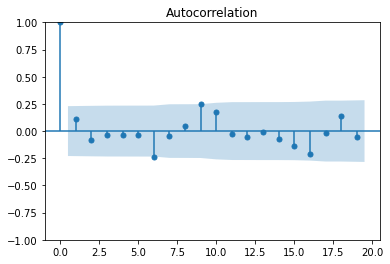

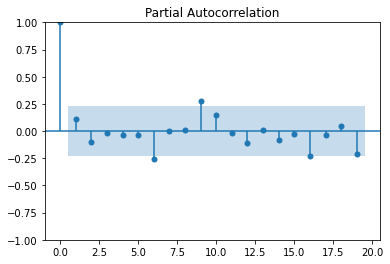

In [64]:

def lag_plots(data):
    """plots acf and pacf plots"""
    plot_acf(data)
    plot_pacf(data)
    
lag_plots(retailEcommercesales_ts[['Growth_rate']])

In [65]:

model = ARIMA(endog = train_df.Growth_rate, exog = train_df.loc[:, ~train_df.columns.isin(['Growth_rate'])], order = (1,0,1))
model_fit = model.fit(method = "innovations_mle")
print(model_fit.summary())

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   51
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 137.021
Date:                Fri, 20 May 2022   AIC                           -206.042
Time:                        11:26:53   BIC                           -140.360
Sample:                    02-01-2016   HQIC                          -180.943
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0378      0.051      0.741      0.459      -0.062       0.138
Uber                        -0.0187      0.006     -3.061      0.002      -0.031      -0.

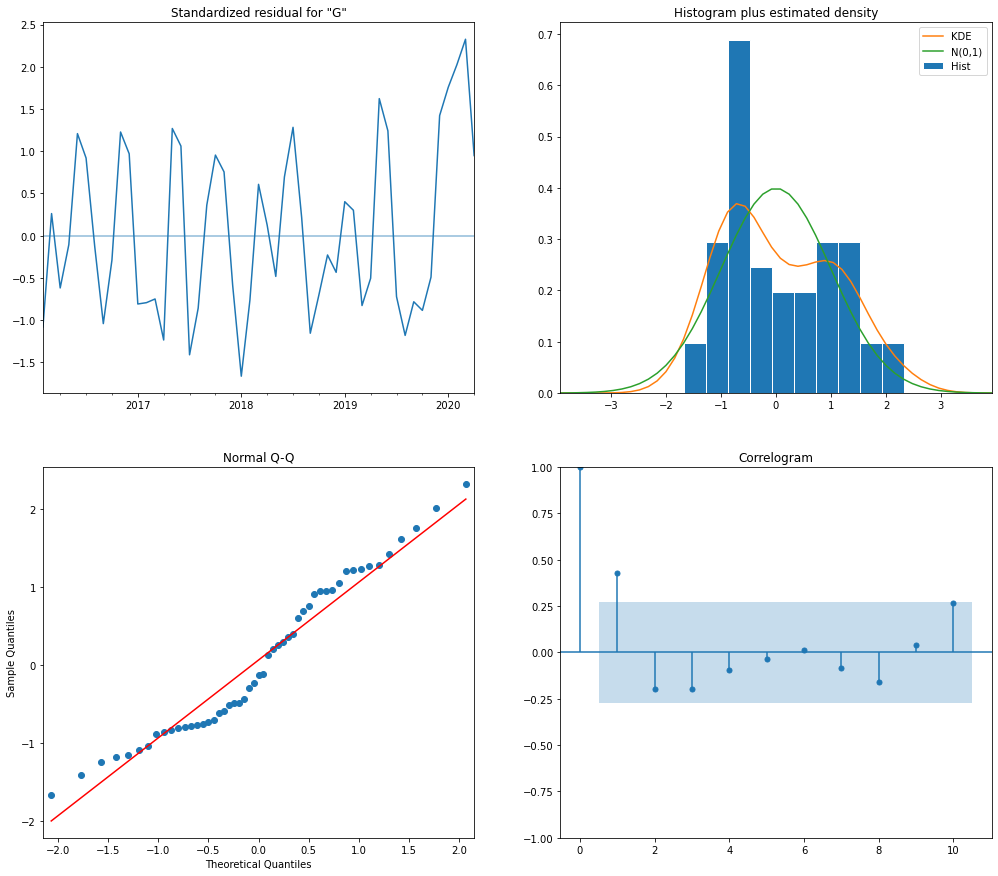

In [66]:
model_fit.plot_diagnostics(figsize=(17,15))
plt.show()

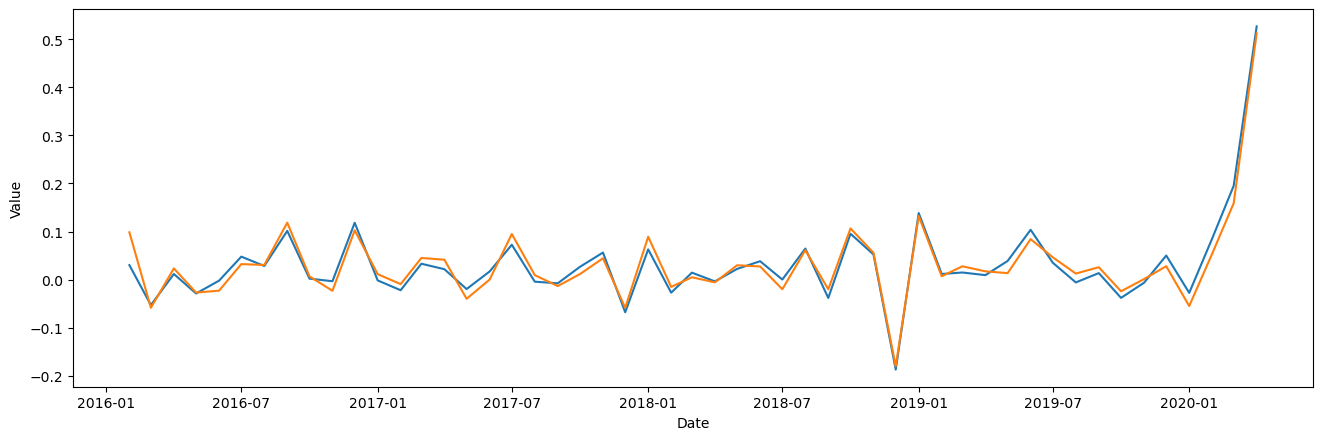

In [67]:
fitted_value = pd.DataFrame({'Original_sales' : train_df['Growth_rate'], 'Fitted_sales' : model_fit.predict()})
plot_df(fitted_value)

In [221]:
np.shape(test_df)

(22, 31)

In [225]:
test_df2 = test_df.drop(columns = 'Growth_rate')

In [41]:

result=seasonal_decompose(retailEcommercesales_ts['Growth_rate'],  model='additive')

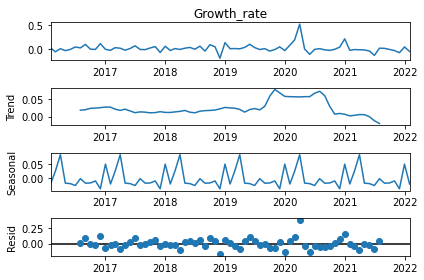

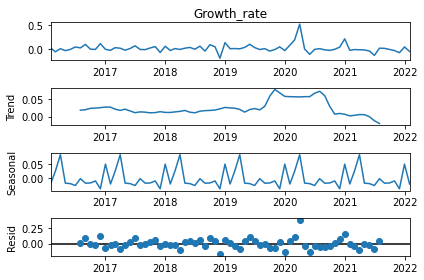

In [42]:
result.plot()

In [68]:
def fit_arima_model(train, dependent_var='Growth_rate', ar_order=1, ma_order=1):
    """ fits arma model to the training data set of GDP"""
    model = ARIMA(endog=train[dependent_var],
                  exog=train.loc[:, ~train.columns.isin([dependent_var])],
                  order=(ar_order, 0, ma_order))
    modelfit = model.fit(method='innovations_mle')
    return modelfit

modelfit = fit_arima_model(train = train_df)
print(modelfit.summary())

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   51
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 137.021
Date:                Fri, 20 May 2022   AIC                           -206.042
Time:                        11:28:30   BIC                           -140.360
Sample:                    02-01-2016   HQIC                          -180.943
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.0378      0.051      0.741      0.459      -0.062       0.138
Uber                        -0.0187      0.006     -3.061      0.002      -0.031      -0.

### Rolling Prediction

In [52]:
def rolling_prediction(train, test, dependent_var='Growth_rate'):
    """ Rolling prediction for test set"""
    train_samples = train.shape[0]
    test_samples = test.shape[0]
    pred_data = pd.DataFrame(columns=None)
    for i in range(train_samples+1, train_samples+test_samples+1):
        modelfit = fit_arima_model(train)

        # Get first row of test set and make prediction
        firstrow_test = np.transpose(pd.DataFrame((test.iloc[0, :])))
        predicted_val = modelfit.forecast(step=1,
                        exog=firstrow_test.loc[:, ~firstrow_test.columns.isin([dependent_var])], dynamic=True)
        predicted_val = pd.DataFrame(predicted_val)
        pred_data = pred_data.append(predicted_val)

        # update training set with one row
        train = pd.concat([train, firstrow_test])

        # Drop first row from test set now
        test = test.drop(f"{firstrow_test.index[0]}")
    return pred_data

In [76]:
train_df.shape

(51, 31)

In [77]:
test_df.shape

(0, 31)

In [69]:
predict_df = rolling_prediction(train_df, test_df)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

In [72]:
predict_df[0]

2020-05-01    0.026081
2020-06-01   -0.131822
2020-07-01    0.195081
2020-08-01    0.132159
2020-09-01    0.060947
2020-10-01   -0.050422
2020-11-01   -0.019186
2020-12-01    0.084709
2021-01-01   -0.181683
2021-02-01    0.204643
2021-03-01   -0.072914
2021-04-01    0.128024
2021-05-01   -0.064027
2021-06-01    0.063233
2021-07-01   -0.093694
2021-08-01   -0.083687
2021-09-01    0.242588
2021-10-01   -0.029559
2021-11-01   -0.174190
2021-12-01    0.048862
2022-01-01    0.059317
2022-02-01   -0.014870
Freq: MS, Name: 0, dtype: float64

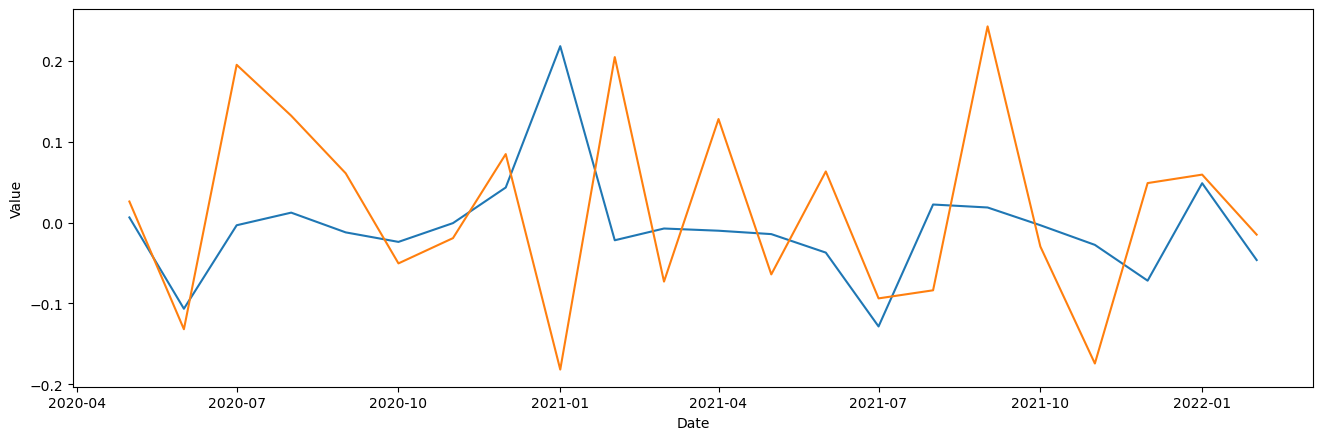

In [73]:
# plot roll sales v/s test growth rate
fitted_value = pd.DataFrame({'Test_growthrate' : test_df['Growth_rate'], 'Rolls_growthrate' : predict_df[0]})
plot_df(fitted_value)

In [ ]:
# to get fitted original sales

def fitted_GDP_plot(modelfit, retailEcommercesales):
    """plots the actual and fitted GDP"""
    # get fitted GDP
    base_GDP = retailEcommercesales['Ecommerce_sales'][0]
    fitted_values = modelfit.predict()
    fitted_GDP = [0]*(len(fitted_values)+1)
    fitted_GDP[0] = base_GDP
    for i, value in enumerate(fitted_values):
        fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)

    # Plot actual and fitted GDP
    Train_Actual_GDP = gdpts[gdpts.index <= train.index[len(train.index)-1]]['GDP']
    fittedandActual_GDP = pd.DataFrame({'Actual GDP': Train_Actual_GDP, 'Fitted GDP': fitted_GDP})
    plot_df(fittedandActual_GDP, width=12, height=4)


fitted_GDP_plot(modelfit, gdpts)

In [88]:
response.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-02-01,1006610,0.030098
2016-03-01,953186,-0.053073


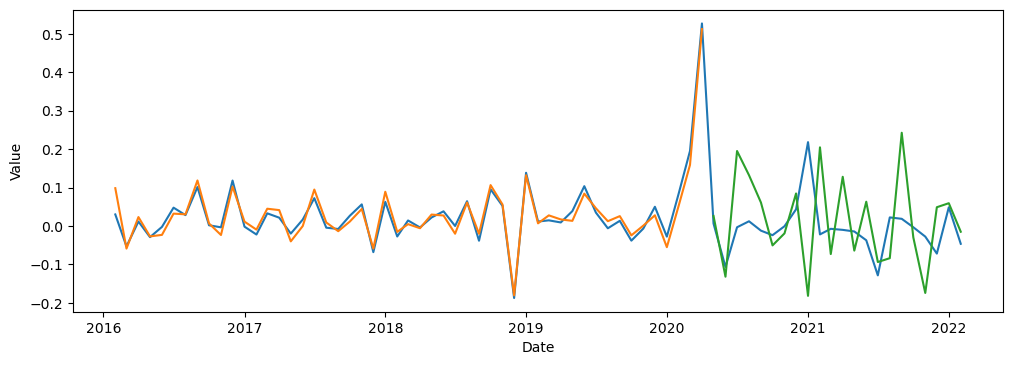

In [74]:
fitted_values = pd.DataFrame({'GDP_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': modelfit.predict(),
                              'Predicted Value': predict_df.squeeze()})
plot_df(fitted_values, width=12, height=4)

In [75]:
# selection of predictors
def predictor_selection(dataframe, year="2005-01-01"):
    temp_data = dataframe.copy()
    q_index = dataframe[(dataframe.index > year)].max()
    for i, qidx in enumerate(q_index):
        if qidx == 100:
            continue
        else:
            temp_data = temp_data.drop(columns = [q_index.index[i]])
    return temp_data

In [107]:
temp_keywordDF = predictor_selection(ecommerce_keyword_ts)
tempkeyword = remove_seasonality(detrend(detrend(normalize(temp_keywordDF))))
print(ecommerce_keyword_ts.shape)
print(temp_keywordDF.shape)

(221, 30)
(221, 29)


In [109]:
tempkeyword2 = tempkeyword.drop(['kijiji'], axis=1)

In [110]:
check_stationarity(tempkeyword2)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than 

All other series are stationary


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than 

In [119]:
# Make predictors dataframe in right form
predictor = make_predictors_df(tempkeyword)   #final_category_df
predictor.shape

(219, 29)

In [195]:
### check size
train_df2, test_df2, extra_df2 = ts_train_test_split(retailEcommercesales_ts['Growth_rate'], temp_df, test_size=0.2)
train_df2.shape

(58, 7)

In [196]:
modelfit = fit_arima_model(train_df2)
print(modelfit.summary())

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            Growth_rate   No. Observations:                   58
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  76.625
Date:                Fri, 20 May 2022   AIC                           -133.251
Time:                        14:49:33   BIC                           -112.646
Sample:                    02-01-2016   HQIC                          -125.225
                         - 11-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.015      1.602      0.109      -0.005       0.053
2          -3.665e-05      0.007     -0.005      0.996      -0.014       0.014
5             -0.0034      0.004     -0.891      0.3

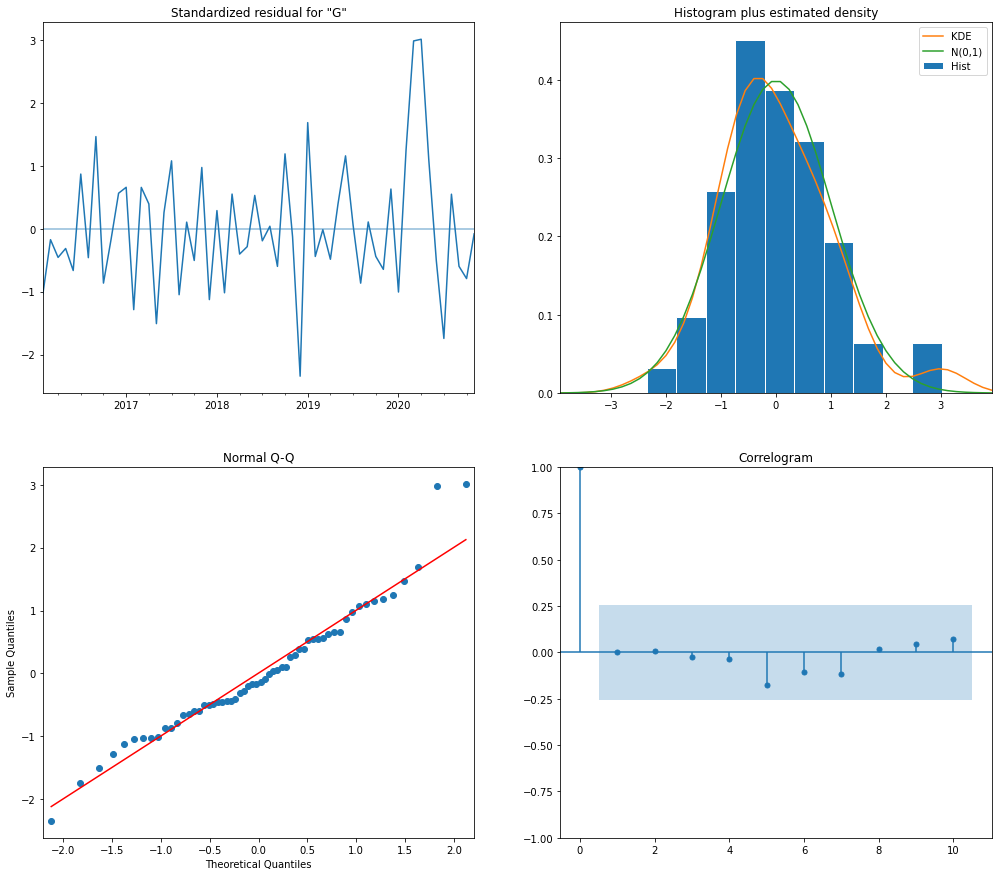

In [197]:
modelfit.plot_diagnostics(figsize=(17,15))
plt.show()

In [198]:
pred_gdpGrowth = rolling_prediction(train_df2, test_df2)

C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init

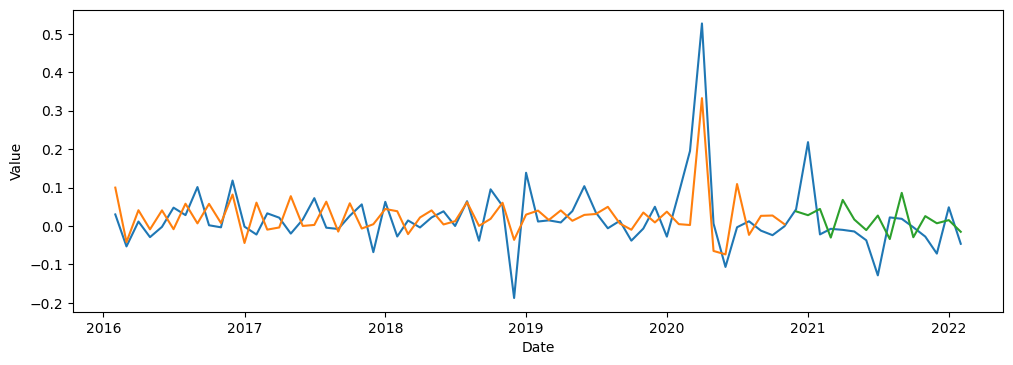

In [199]:
fitted_values = pd.DataFrame({'GDP_GrowthRate': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value': modelfit.predict(),
                              'Predicted Value': pred_gdpGrowth.squeeze()})
plot_df(fitted_values, width=12, height=4)

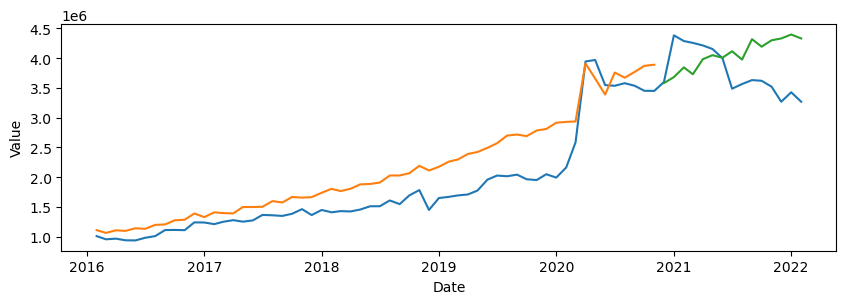

In [200]:
# Plot fitted and predicted GDP

base_GDP = retailEcommercesales_ts['Ecommerce_sales'][0]
fitted_values = modelfit.predict()
fitted_GDP = [0]*(len(fitted_values)+1)
fitted_GDP[0] = base_GDP
for i, value in enumerate(fitted_values):
    fitted_GDP[i+1] = fitted_GDP[i]*(1 + value)
fitted_GDP_df = pd.DataFrame(fitted_GDP[1:])
fitted_GDP_df.index = train_df2.index

base_GDP = retailEcommercesales_ts[retailEcommercesales_ts.index == train_df2.index[-1]]['Ecommerce_sales'][0]
predicted_GDP = [0]*(len(pred_gdpGrowth.squeeze())+1)
predicted_GDP[0] = base_GDP
for i, value in enumerate(pred_gdpGrowth.squeeze()):
    predicted_GDP[i+1] = predicted_GDP[i]*(1 + value)
predicted_GDP_df = pd.DataFrame(predicted_GDP[1:])
predicted_GDP_df.index = pred_gdpGrowth.index

# Plot actual and fitted GDP
Actual_GDP = retailEcommercesales_ts['Ecommerce_sales']
fittedandActual_GDP = pd.DataFrame({'Actual GDP': Actual_GDP,
                                    'Fitted GDP': fitted_GDP_df.squeeze(),
                                    'Predicted GDP': predicted_GDP_df.squeeze()
                                   })
plot_df(fittedandActual_GDP, width=10, height=3)

In [183]:
ds_ecommerce_keyword.index

DatetimeIndex(['2004-03-01', '2004-04-01', '2004-05-01', '2004-06-01',
               '2004-07-01', '2004-08-01', '2004-09-01', '2004-10-01',
               '2004-11-01', '2004-12-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=219, freq=None)

## lasso 

In [184]:
tempdf = pd.merge(retailEcommercesales_ts[['Growth_rate']], ds_ecommerce_keyword,left_index=True,right_index=True)
tempdf

,Growth_rate,Uber,DoorDash,SkipTheDishes,Walmart,Costco,Real Canadian Superstore,alibaba,newegg canada,ebay,...,Sportchek,square online,PayPal,Western Union,TD Canada Trust,Scotiabank,Royal Bank of Canada,Google Pay,Apple Pay,Mastercard
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-01,0.030098,1.440110,0.048186,0.491848,-0.586938,1.378656,0.193093,1.782665,0.244078,-2.341263,...,1.927608,1.240967,1.691683,-0.979883,0.985604,0.142583,0.801235,0.367542,0.143763,-0.220103
2016-03-01,-0.053073,-1.092471,0.016112,-0.402421,0.370697,-1.235847,-0.285549,0.864225,0.050397,1.296753,...,-5.474613,0.014635,-0.887741,0.084700,-0.316519,0.293649,-1.316932,-0.420665,-0.349003,-1.115573
2016-04-01,0.011638,0.105339,-0.171858,1.617627,0.447926,1.261865,0.646948,-2.084943,-0.163048,-1.119449,...,5.601750,2.190324,0.227827,0.294755,-0.118695,-0.350421,1.646164,-0.015908,0.457535,2.676853
2016-05-01,-0.028947,-0.562376,0.241675,-3.063167,-0.796558,-0.192532,2.141621,0.334887,2.261919,0.657068,...,-5.852172,-2.609852,0.039281,-0.088088,0.965382,0.467880,1.216333,0.192658,2.768617,-2.298914
2016-06-01,-0.002234,1.298430,-0.172902,1.394501,1.218129,0.606938,-6.216650,1.721849,-4.731353,-0.275227,...,5.843825,1.156004,-0.111950,0.325435,-0.501155,-0.675718,-4.582163,-0.093285,-2.713524,2.839324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,-0.003243,1.232074,-0.257936,3.037721,-0.079190,0.573982,2.849298,0.570149,-2.831928,-0.231191,...,4.631953,-0.756938,-0.422921,-0.053643,1.316923,0.642656,-1.283907,0.333959,0.060650,-1.692039
2021-11-01,-0.027532,-1.185445,-0.453514,-5.552854,-0.095494,0.016478,-0.551021,0.912238,2.559687,-0.154127,...,-2.773479,-2.711075,0.087072,0.271792,-0.843610,-0.314095,-0.112623,0.276123,0.069635,2.068964
2021-12-01,-0.071779,-0.407104,1.556121,4.803903,0.225924,-0.038449,0.339090,-0.163443,0.062584,1.383473,...,-2.700278,3.681707,0.024878,-0.135896,-0.005568,-0.121919,0.614602,-1.151134,-0.096591,-1.210564


In [185]:
y_train = tempdf[['Growth_rate']]
x_train = tempdf.drop(['Growth_rate'],axis=1)

In [186]:
x_train.shape


(73, 30)

In [187]:
y_train.shape

(73, 1)

In [189]:
y_train.tail()

,Growth_rate
Date,
2021-10-01,-0.003243
2021-11-01,-0.027532
2021-12-01,-0.071779
2022-01-01,0.048695
2022-02-01,-0.046279


In [190]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import scale 

model = Lasso(alpha=0.001,fit_intercept= True, normalize = True, positive= False, selection = 'cyclic')

model.fit(x_train,y_train)


C:\Users\hp\miniconda3\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), Lasso())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


Lasso(alpha=0.001, normalize=True)

In [191]:
temp_array = model.coef_

In [192]:
len(model.coef_)

30

In [193]:
temp_list_key = []
for i in range(len(temp_array)):
    if temp_array[i] != 0 :
        temp_list_key.append(i)
print(temp_list_key)

[2, 5, 13, 17, 19, 22]


In [194]:
temp_df = pd.DataFrame()
for i in temp_list_key:
    temp_df[str(i)] = x_train.iloc[:,i]

print(temp_df)

                   2         5        13        17        19        22
Date                                                                  
2016-02-01  0.491848  0.193093 -0.074039  3.742509  3.284051  1.691683
2016-03-01 -0.402421 -0.285549 -0.031443 -3.872550 -1.011438 -0.887741
2016-04-01  1.617627  0.646948  0.033862 -3.132463 -2.602530  0.227827
2016-05-01 -3.063167  2.141621 -0.089492  3.180654  2.153002  0.039281
2016-06-01  1.394501 -6.216650  0.204247  0.497790 -0.312172 -0.111950
...              ...       ...       ...       ...       ...       ...
2021-10-01  3.037721  2.849298 -0.388069 -0.410586 -0.277833 -0.422921
2021-11-01 -5.552854 -0.551021  0.418706  0.010901  0.062434  0.087072
2021-12-01  4.803903  0.339090 -0.574444  0.268879 -0.134234  0.024878
2022-01-01  0.483464 -0.334380  0.505510 -0.138073 -0.967734 -0.223899
2022-02-01 -4.789930  0.193093 -0.303817  0.014534  1.261175  0.049755

[73 rows x 6 columns]


In [212]:
model.coef_

array([ 0.        ,  0.        ,  0.00240302,  0.        , -0.        ,
       -0.00013845,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.04529451,  0.        ,
       -0.        ,  0.        , -0.0008379 ,  0.        , -0.00118373,
        0.        ,  0.        ,  0.04169599, -0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        ,  0.        ])

In [218]:
tempdf_lasso = pd.DataFrame(model.predict(x_train))

In [221]:
tempdf_lasso.head(2)

,0
Date,
2016-02-01,0.080876
2016-03-01,-0.015364


In [220]:
tempdf_lasso.index = y_train.index

In [217]:
y_train.index

DatetimeIndex(['2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01',
               '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01',
               '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01',
               '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01',
               '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01',
               '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01',
               '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
      

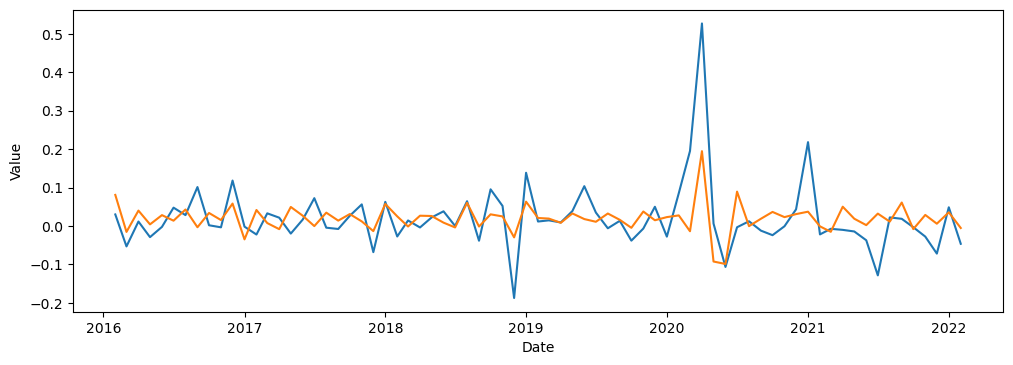

In [223]:
fitted_values = pd.DataFrame({'x_train': retailEcommercesales_ts['Growth_rate'],
                              'Fitted Value':model.predict(x_train) })
plot_df(fitted_values, width=12, height=4)

In [262]:
from scipy.stats import pearsonr

#categoryts.index = pd.to_datetime(categoryts.index)
cols = list()
data = pd.merge(retailEcommercesales, temp_data, left_index=True, right_index=True)

for i in range(0, data.iloc[:,2:].shape[1]):
    
    corr, _ = pearsonr(data['Ecommerce_sales'], data.iloc[:, i+2])
    if abs(corr) > 0.6:
        cols.append(data.columns[i+2])

In [266]:
new_predictors = temp_data[cols]

In [264]:
print(cols)

['23', '170', '71', '11', '67', '179', '95', '423', '46', '121', '1176', '287', '13', '380', '1010', '726', '48', '255', '664', '60', '841', '662', '1150', '650', '158', '271', '270', '794', '882', '293', '205', '1188', '185', '206', '918', '894', '960', '961', '784', '408', '832', '1139', '107', '343', '334', '728', '1162', '12', '672', '49']


In [230]:
retailEcommercesales.set_index("Date", inplace = True)

In [232]:
retailEcommercesales.index = pd.to_datetime(retailEcommercesales.index)


In [247]:
temp_data = pd.read_csv("gdp_category_ts.csv", index_col = 0)
temp_data.head(2)

,569,23,47,815,170,249,71,276,634,250,...,53,342,1159,1214,670,12,566,672,673,49
date,,,,,,,,,,,,,,,,,,,,,
2004-01-01,74,90,91,94,89,86,76,57,60,90,...,100,90,95,77,68,100,88,74,91,88
2004-02-01,70,85,89,93,88,87,72,58,52,98,...,96,100,95,91,77,99,96,79,82,100


In [255]:
temp_data.rename(index={'date': 'Date'}, inplace=True)

In [258]:
temp_data.index = pd.to_datetime(temp_data.index) 